
# VQ-VAE + PixelCNN (Combined) — with Inpainting & Metrics

This notebook combines:
- **Phase 1 (VQ-VAE / Codebook training)** — all original code, concatenated into a single cell.
- **Phase 2 (PixelCNN / Prior training)** — all original code, concatenated into a single cell.
- **Part C: Inpainting + Metrics** — a single cell that performs latent-space inpainting using the trained models and reports MSE, PSNR, SSIM, and a placeholder for FID, as per the project guidelines.

> Note: No hyperparameters were changed. The first two cells contain your original code verbatim.
> You may need to align variable/function names in the third cell with those defined by the first two.


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Removing old local checkpoints...
Removing old local results...
Directory contents:
['.config', 'drive', 'results', 'emoji_data', 'checkpoints', 'sample_data']
VQ-VAE EMOJI GENERATION - PHASE 1: CODEBOOK TRAINING
Train: 936, Val: 104
✓ Found final checkpoint in Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/vqvae_final.pt
✓ VQ-VAE checkpoint loaded, resuming from epoch 100

✓ Resuming VQ-VAE training...

PHASE 1: VQ-VAE TRAINING WITH CODEBOOK MONITORING
Target: ≥50.0% codebook utilization

✓ Local temp checkpoint saved: ./checkpoints/vqvae_epoch_99.pt
✓ Checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/vqvae_final.pt

PHASE 1 COMPLETE
Final codebook usage: 71.48% (183/256)
Best codebook usage: 71.48%
✓ SUCCESS: Codebook utilization target achieved!
Resu

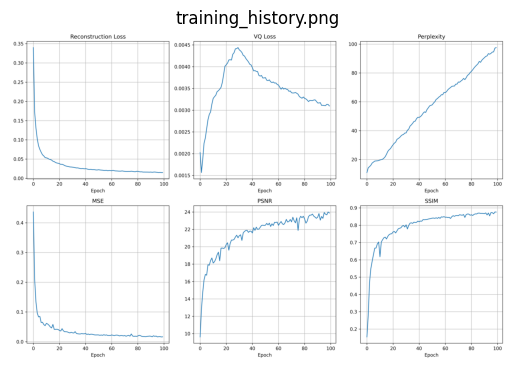

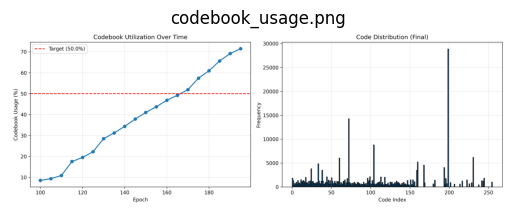

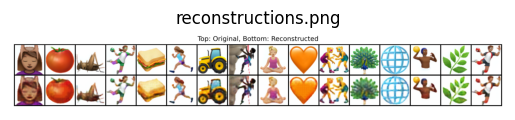


Contents of /content/drive/MyDrive/vqvae_pixelcnn_results/results/experiment_results.csv:
             timestamp      data_dir checkpoint_dir results_dir                                drive_save_base  image_size  batch_size  num_workers  num_hiddens  num_residual_hiddens  num_residual_layers  embedding_dim  num_embeddings  commitment_cost  decay  num_epochs_vqvae  learning_rate_vqvae  min_codebook_usage  check_usage_every     experiment_name                             notes device   phase  codebook_usage_percent  active_codes  best_codebook_usage  final_perplexity  final_recon_loss  final_vq_loss  final_mse  final_psnr  final_ssim  target_achieved  training_completed
0  2025-10-25 20:29:36  ./emoji_data  ./checkpoints   ./results  /content/drive/MyDrive/vqvae_pixelcnn_results          64          64            2          128                    32                    2             64             256             0.01   0.95               100               0.0003                50.0    

In [ ]:
# === VQ-VAE (Codebook Training - Phase 1) ===
# Source: Codebook_Training_Phase_1.ipynb
# All code below is copied verbatim from the original notebook (concatenated).

# Delete old incompatible checkpoints and start fresh
import shutil
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore')

# Import Google Drive
from google.colab import drive


# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")


# Define base save path in Google Drive
# You can change 'My Drive/your_project_folder' to your desired path in Drive
DRIVE_SAVE_BASE = '/content/drive/MyDrive/vqvae_pixelcnn_results'


# Create local directories (used as temp or fallback)
checkpoint_dir = './checkpoints'
results_dir = './results'

# Clean local directories
if os.path.exists(checkpoint_dir):
    print("Removing old local checkpoints...")
    shutil.rmtree(checkpoint_dir)

if os.path.exists(results_dir):
    print("Removing old local results...")
    shutil.rmtree(results_dir)

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Create Drive directories
os.makedirs(os.path.join(DRIVE_SAVE_BASE, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(DRIVE_SAVE_BASE, 'results'), exist_ok=True)


# ---- Cell Separator (from original notebook) ----

# ls # Replaced with Python equivalent
print("Directory contents:")
print(os.listdir('.'))


# ---- Cell Separator (from original notebook) ----

"""
VQ-VAE Emoji Generation - Phase 1: Codebook Training
Focus on achieving good codebook utilization (50-60%) before proceeding
"""

# ============================================================================
# Configuration Management
# ============================================================================

# Define all configurations in JSON format
EXPERIMENT_CONFIGS = {
    # Paths
    "data_dir": "./emoji_data", # Local path for dataset
    "checkpoint_dir": checkpoint_dir, # Local temp path for checkpoints
    "results_dir": results_dir,     # Local temp path for results
    "drive_save_base": DRIVE_SAVE_BASE, # Base path in Google Drive

    # Data
    "image_size": 64,
    "batch_size": 64,
    "num_workers": 2,

    # VQ-VAE Architecture
    "num_hiddens": 128,
    "num_residual_hiddens": 32,
    "num_residual_layers": 2,
    "embedding_dim": 64,
    "num_embeddings": 256,
    "commitment_cost": 0.01,
    "decay": 0.95,

    # Training
    "num_epochs_vqvae": 100,
    "learning_rate_vqvae": 3e-4,

    # Codebook monitoring
    "min_codebook_usage": 50.0,
    "check_usage_every": 5,

    # Experiment metadata
    "experiment_name": "commitment_cost_10",
    "notes": "Decreasing commitment cost to 10"
}


# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Configuration class that loads from JSON dict"""
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

        # Add device (not in JSON as it's system-dependent)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def to_dict(self):
        """Convert config back to dictionary for CSV export"""
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}

# config = Config(EXPERIMENT_CONFIGS) # Define config inside main


# ============================================================================
# Dataset
# ============================================================================

class EmojiDataset(Dataset):
    def __init__(self, data_dir, image_size=64, transform=None):
        self.data_dir = data_dir
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        return self.transform(image)

def download_emoji_dataset(data_dir):
    print("Downloading emoji dataset...")
    try:
        from datasets import load_dataset
        dataset = load_dataset("valhalla/emoji-dataset", split="train")

        print(f"Downloaded {len(dataset)} emojis")
        print("Saving images to disk...")

        os.makedirs(data_dir, exist_ok=True)
        for idx, item in enumerate(tqdm(dataset)):
            img = item['image']
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(os.path.join(data_dir, f'emoji_{idx:05d}.png'))

        print(f"Saved {len(dataset)} emoji images to {data_dir}")
    except Exception as e:
        print(f"Error downloading dataset: {e}")

# ============================================================================
# VQ-VAE Components
# ============================================================================

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        embed = torch.randn(num_embeddings, embedding_dim)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(num_embeddings))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, inputs):
        input_shape = inputs.shape
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embed**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embed.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embed)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(encodings.sum(0), alpha=1 - self.decay)
            dw = torch.matmul(encodings.t(), flat_input)
            self.embed_avg.data.mul_(self.decay).add_(dw, alpha=1 - self.decay)

            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_normalized)

        e_latent_loss = F.mse_loss(quantized.detach(), flat_input)
        loss = self.commitment_cost * e_latent_loss
        quantized = flat_input + (quantized - flat_input).detach()

        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], self.embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity, encoding_indices

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, num_residual_hiddens, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_residual_hiddens),
            nn.ReLU(),
            nn.Conv2d(num_residual_hiddens, num_hiddens, 1, bias=False),
            nn.BatchNorm2d(num_hiddens)
        )

    def forward(self, x):
        return x + self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.layers = nn.ModuleList([
            ResidualBlock(in_channels, num_hiddens, num_residual_hiddens)
            for _ in range(num_residual_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_hiddens // 2, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(num_hiddens // 2, num_hiddens, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_hiddens, num_hiddens, 3, padding=1)
        self.residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return self.residual_stack(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(embedding_dim, num_hiddens, 3, padding=1)
        self.residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.conv_trans1 = nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, 4, stride=2, padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(num_hiddens // 2, 3, 4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.residual_stack(x)
        x = F.relu(self.conv_trans1(x))
        return torch.tanh(self.conv_trans2(x))

class VQVAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(3, config.num_hiddens, config.num_residual_layers, config.num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(config.num_hiddens, config.embedding_dim, 1)
        self.vq = VectorQuantizerEMA(config.num_embeddings, config.embedding_dim, config.commitment_cost, decay=config.decay)
        self.decoder = Decoder(config.embedding_dim, config.num_hiddens, config.num_residual_layers, config.num_residual_hiddens)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        quantized, vq_loss, perplexity, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, perplexity, encoding_indices

    def encode(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        _, _, _, encoding_indices = self.vq(z)
        B = x.shape[0]
        return encoding_indices.view(B, -1)

# ============================================================================
# Metrics
# ============================================================================

def calculate_mse(original, reconstructed):
    return F.mse_loss(reconstructed, original).item()

def calculate_psnr(original, reconstructed, max_val=2.0):
    mse = F.mse_loss(reconstructed, original)
    return (10 * torch.log10(max_val**2 / mse)).item()

def calculate_ssim(original, reconstructed):
    orig_np = (original.detach().cpu().numpy() + 1) / 2
    recon_np = (reconstructed.detach().cpu().numpy() + 1) / 2
    ssim_scores = [ssim(orig_np[i].transpose(1, 2, 0), recon_np[i].transpose(1, 2, 0),
                       channel_axis=2, data_range=1.0) for i in range(orig_np.shape[0])]
    return np.mean(ssim_scores)

def calculate_codebook_usage(model, dataloader, device, num_embeddings):
    """Calculate codebook utilization percentage"""
    model.eval()
    all_codes = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            codes = model.encode(batch)
            all_codes.append(codes.cpu())

    all_codes = torch.cat(all_codes, dim=0).numpy().flatten()
    unique_codes = len(np.unique(all_codes))
    usage_percentage = (unique_codes / num_embeddings) * 100

    return usage_percentage, unique_codes, all_codes

# ============================================================================
# Trainer with Codebook Monitoring
# ============================================================================

class Trainer:
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate_vqvae)
        self.history = {'recon_loss': [], 'vq_loss': [], 'total_loss': [], 'perplexity': [],
                       'mse': [], 'psnr': [], 'ssim': [], 'codebook_usage': []}
        self.start_epoch = 0
        self.best_usage = 0

        # Define Drive paths based on config
        self.drive_checkpoint_path = os.path.join(config.drive_save_base, 'checkpoints', 'vqvae_final.pt')
        self.drive_best_usage_path = os.path.join(config.drive_save_base, 'checkpoints', 'vqvae_best_usage.pt')
        self.drive_epoch_path_template = os.path.join(config.drive_save_base, 'checkpoints', 'vqvae_epoch_{}.pt')
        self.drive_results_csv_path = os.path.join(config.drive_save_base, 'results', 'experiment_results.csv')
        self.drive_phase1_summary_path = os.path.join(config.drive_save_base, 'results', 'phase1_summary.json')


    def save_checkpoint(self, epoch, is_best_usage=False):
        # Save locally first (as temp)
        local_filepath = os.path.join(self.config.checkpoint_dir, f'vqvae_epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_usage': self.best_usage
        }, local_filepath)
        print(f"✓ Local temp checkpoint saved: {local_filepath}")

        # Determine final Drive path
        if is_best_usage:
            drive_filepath = self.drive_best_usage_path
        elif epoch == self.config.num_epochs_vqvae - 1:
             drive_filepath = self.drive_checkpoint_path # final checkpoint
        else:
             drive_filepath = self.drive_epoch_path_template.format(epoch + 1)

        # Copy to Google Drive
        try:
            os.makedirs(os.path.dirname(drive_filepath), exist_ok=True) # Ensure Drive path exists
            shutil.copyfile(local_filepath, drive_filepath)
            print(f"✓ Checkpoint copied to Google Drive: {drive_filepath}")
        except Exception as e:
            print(f"✗ Error copying checkpoint to Google Drive: {e}")

        # Clean up local temp file
        os.remove(local_filepath)


    def load_checkpoint(self):
        # Try loading final checkpoint from Drive first
        if os.path.exists(self.drive_checkpoint_path):
            filepath_to_load = self.drive_checkpoint_path
            print(f"✓ Found final checkpoint in Drive: {filepath_to_load}")
        elif os.path.exists(self.drive_best_usage_path):
             filepath_to_load = self.drive_best_usage_path
             print(f"✓ Found best usage checkpoint in Drive: {filepath_to_load}")
        else:
            print("✗ No VQ-VAE checkpoint found in Google Drive.")
            return False

        try:
            checkpoint = torch.load(filepath_to_load, map_location=self.config.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.history = checkpoint['history']
            self.start_epoch = checkpoint['epoch'] + 1
            self.best_usage = checkpoint.get('best_usage', 0) # Load best_usage if available
            print(f"✓ VQ-VAE checkpoint loaded, resuming from epoch {self.start_epoch}")
            return True
        except Exception as e:
            print(f"✗ Error loading VQ-VAE checkpoint from {filepath_to_load}: {e}")
            return False


    def train_epoch(self, dataloader):
        self.model.train()
        epoch_recon_loss = epoch_vq_loss = epoch_perplexity = 0
        pbar = tqdm(dataloader, desc="Training")
        for batch in pbar:
            batch = batch.to(self.config.device)
            recon, vq_loss, perplexity, _ = self.model(batch)
            recon_loss = F.mse_loss(recon, batch)
            loss = recon_loss + vq_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_recon_loss += recon_loss.item()
            epoch_vq_loss += vq_loss.item()
            epoch_perplexity += perplexity.item()
            pbar.set_postfix({'recon_loss': recon_loss.item(), 'vq_loss': vq_loss.item(), 'perplexity': perplexity.item()})
        n = len(dataloader)
        return {'recon_loss': epoch_recon_loss/n, 'vq_loss': epoch_vq_loss/n, 'perplexity': epoch_perplexity/n}

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        all_original, all_recon = [], []
        for batch in dataloader:
            batch = batch.to(self.config.device)
            recon, _, _, _ = self.model(batch)
            all_original.append(batch)
            all_recon.append(recon)
        original = torch.cat(all_original, dim=0)
        reconstructed = torch.cat(all_recon, dim=0)
        return {'mse': calculate_mse(original, reconstructed),
                'psnr': calculate_psnr(original, reconstructed),
                'ssim': calculate_ssim(original[:64], reconstructed[:64])}

    def train(self, train_loader, val_loader):
        print(f"\n{'='*80}")
        print(f"PHASE 1: VQ-VAE TRAINING WITH CODEBOOK MONITORING")
        print(f"Target: ≥{self.config.min_codebook_usage}% codebook utilization")
        print(f"{'='*80}\n")

        total_epochs = self.config.num_epochs_vqvae

        for epoch in range(self.start_epoch, total_epochs):
            print(f"\nEpoch {epoch+1}/{total_epochs}")

            train_metrics = self.train_epoch(train_loader)
            val_metrics = self.evaluate(val_loader)

            # Check codebook usage periodically
            if (epoch + 1) % self.config.check_usage_every == 0:
                usage_pct, unique_codes, _ = calculate_codebook_usage(self.model, train_loader, self.config.device, self.config.num_embeddings)
                # Only append if we started training this epoch or later
                if epoch >= self.start_epoch:
                     self.history['codebook_usage'].append(usage_pct)

                print(f"\n{'─'*60}")
                print(f"📊 CODEBOOK USAGE CHECK (Epoch {epoch+1})")
                print(f"{'─'*60}")
                print(f"Active codes: {unique_codes}/{self.config.num_embeddings}")
                print(f"Usage: {usage_pct:.2f}%")

                if usage_pct > self.best_usage:
                    self.best_usage = usage_pct
                    print(f"✓ New best usage: {usage_pct:.2f}%")
                    self.save_checkpoint(epoch, is_best_usage=True)


                if usage_pct >= self.config.min_codebook_usage:
                    print(f"✓ TARGET REACHED! ({usage_pct:.2f}% ≥ {self.config.min_codebook_usage}%)")
                else:
                    remaining = self.config.min_codebook_usage - usage_pct
                    print(f"⚠ Need {remaining:.2f}% more to reach target")
                print(f"{'─'*60}\n")

            metrics = {**train_metrics, **val_metrics}
            # Only append if we started training this epoch or later
            if epoch >= self.start_epoch:
                 for key, value in metrics.items():
                     if key != 'codebook_usage': # codebook_usage is handled separately
                         self.history[key].append(value)

            print(f"Recon: {metrics['recon_loss']:.4f}, VQ: {metrics['vq_loss']:.4f}, Perplexity: {metrics['perplexity']:.2f}")
            print(f"MSE: {metrics['mse']:.4f}, PSNR: {metrics['psnr']:.2f}, SSIM: {metrics['ssim']:.4f}")

            # Save checkpoint periodically
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(epoch)

        # Save final checkpoint
        self.save_checkpoint(total_epochs - 1)

        # Final usage check and report
        final_usage, final_unique, _ = calculate_codebook_usage(self.model, train_loader, self.config.device, self.config.num_embeddings)
        print(f"\n{'='*80}")
        print(f"PHASE 1 COMPLETE")
        print(f"{'='*80}")
        print(f"Final codebook usage: {final_usage:.2f}% ({final_unique}/{self.config.num_embeddings})")
        print(f"Best codebook usage: {self.best_usage:.2f}%")

        if final_usage >= self.config.min_codebook_usage:
            print(f"✓ SUCCESS: Codebook utilization target achieved!")
            return True, self.history
        else:
            print(f"⚠ WARNING: Codebook utilization below target ({final_usage:.2f}% < {self.config.min_codebook_usage}%)")
            print(f"Consider: 1) Training longer, 2) Reducing num_embeddings, 3) Adjusting commitment_cost")
            return False, self.history

# ============================================================================
# Visualization
# ============================================================================

def plot_training_history(history, save_path):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0, 0].plot(history['recon_loss'])
    axes[0, 0].set_title('Reconstruction Loss')
    axes[0, 1].plot(history['vq_loss'])
    axes[0, 1].set_title('VQ Loss')
    axes[0, 2].plot(history['perplexity'])
    axes[0, 2].set_title('Perplexity')
    axes[1, 0].plot(history['mse'])
    axes[1, 0].set_title('MSE')
    axes[1, 1].plot(history['psnr'])
    axes[1, 1].set_title('PSNR')
    axes[1, 2].plot(history['ssim'])
    axes[1, 2].set_title('SSIM')
    for ax in axes.flat:
        ax.grid(True)
        ax.set_xlabel('Epoch')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_reconstructions(model, dataloader, device, save_path, num_images=8):
    model.eval()
    images = next(iter(dataloader))[:num_images].to(device)
    with torch.no_grad():
        reconstructions, _, _, _ = model(images)
    images, reconstructions = (images + 1) / 2, (reconstructions + 1) / 2
    comparison = torch.cat([images, reconstructions])
    grid = make_grid(comparison, nrow=num_images, padding=2)
    plt.figure(figsize=(16, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title('Top: Original, Bottom: Reconstructed')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_codebook_usage(history, all_codes, save_path, trainer_start_epoch, config_check_usage_every, config_min_codebook_usage, config_num_embeddings):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Usage over time
    if len(history['codebook_usage']) > 0:
        # Ensure epochs align correctly with potentially resumed training
        epochs = [e * config_check_usage_every for e in range(1, len(history['codebook_usage']) + 1)]
        # Adjust epochs if training was resumed from a later epoch
        if trainer_start_epoch > 0:
            # Find the closest check_usage_every multiple to start_epoch
            start_check_idx = (trainer_start_epoch + config_check_usage_every - 1) // config_check_usage_every
            epochs = [e * config_check_usage_every for e in range(start_check_idx, start_check_idx + len(history['codebook_usage']))]

        axes[0].plot(epochs, history['codebook_usage'], marker='o', linewidth=2)
        axes[0].axhline(y=config_min_codebook_usage, color='r', linestyle='--', label=f'Target ({config_min_codebook_usage}%)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Codebook Usage (%)')
        axes[0].set_title('Codebook Utilization Over Time')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # Histogram
    axes[1].hist(all_codes, bins=config_num_embeddings, edgecolor='black')
    axes[1].set_xlabel('Code Index')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Code Distribution (Final)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def save_results_to_csv(config, results, save_path):
    """Save experiment config and results to CSV"""
    import csv
    from datetime import datetime

    # Combine config and results
    row_data = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        **config.to_dict(),
        **results
    }

    # Check if file exists to determine if we need headers
    file_exists = os.path.exists(save_path)

    with open(save_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=row_data.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row_data)

    print(f"Results appended to: {save_path}")

# ============================================================================
# Main
# ============================================================================

def main():
    print("="*80)
    print("VQ-VAE EMOJI GENERATION - PHASE 1: CODEBOOK TRAINING")
    print("="*80)

    # Define config inside main
    config = Config(EXPERIMENT_CONFIGS)


    # Ensure Drive base path exists (handled by initial mounting cell)
    # os.makedirs(config.drive_save_base, exist_ok=True)
    # os.makedirs(os.path.join(config.drive_save_base, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(config.drive_save_base, 'results'), exist_ok=True)


    # Dataset
    if not os.path.exists(config.data_dir) or not os.listdir(config.data_dir):
        os.makedirs(config.data_dir, exist_ok=True)
        download_emoji_dataset(config.data_dir)

    dataset = EmojiDataset(config.data_dir, config.image_size)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

    # Train VQ-VAE
    vqvae = VQVAE(config).to(config.device)
    trainer = Trainer(vqvae, config)

    # Check if training is already completed
    if trainer.load_checkpoint():
         # Check if the loaded checkpoint corresponds to the final epoch
         if trainer.start_epoch > config.num_epochs_vqvae:
              print("\n✓ VQ-VAE training already completed.")
         else:
              print("\n✓ Resuming VQ-VAE training...")
              success, history = trainer.train(train_loader, val_loader)
              # Only plot history if training was actually run
              if success or trainer.start_epoch <= config.num_epochs_vqvae:
                   plot_training_history(history, os.path.join(config.drive_save_base, 'results', 'training_history.png'))
                   # Final codebook analysis plot needs the full history and all codes
                   # Recalculate or load all_codes if needed for plotting after resume
                   # For simplicity, recalculating here.
                   usage_pct, unique_codes, all_codes = calculate_codebook_usage(vqvae, train_loader, config.device, config.num_embeddings)
                   plot_codebook_usage(history, all_codes, os.path.join(config.drive_save_base, 'results', 'codebook_usage.png'), trainer.start_epoch, config.check_usage_every, config.min_codebook_usage, config.num_embeddings)

    else:
        # No checkpoint found, start fresh training
        print("\n✓ Starting VQ-VAE training from scratch...")
        success, history = trainer.train(train_loader, val_loader)
        plot_training_history(history, os.path.join(config.drive_save_base, 'results', 'training_history.png'))

        # Final codebook analysis
        usage_pct, unique_codes, all_codes = calculate_codebook_usage(vqvae, train_loader, config.device, config.num_embeddings)
        plot_codebook_usage(history, all_codes, os.path.join(config.drive_save_base, 'results', 'codebook_usage.png'), trainer.start_epoch, config.check_usage_every, config.min_codebook_usage, config.num_embeddings)

        if not success:
            print("\n⚠ Phase 1 did not reach target codebook usage. Review suggestions above.")
            # Optionally, you might stop or proceed with a warning
            # return # Uncomment to stop


    # Visualize results
    plot_reconstructions(vqvae, val_loader, config.device, os.path.join(config.drive_save_base, 'results', 'reconstructions.png'), num_images=16)


    # Save summary (to Drive)
    # Ensure metrics from loaded history are used if training was completed/resumed
    if trainer.history['perplexity']: # Check if history has data
        final_perplexity = trainer.history['perplexity'][-1]
        final_recon_loss = trainer.history['recon_loss'][-1]
        final_vq_loss = trainer.history['vq_loss'][-1]
        final_mse = trainer.history['mse'][-1]
        final_psnr = trainer.history['psnr'][-1]
        final_ssim = trainer.history['ssim'][-1]
    else: # If no training was run (e.g., loaded completed checkpoint), calculate final metrics
        final_metrics = trainer.evaluate(val_loader)
        # This might not be accurate if no training was run, but provides some value
        usage_pct, unique_codes, _ = calculate_codebook_usage(vqvae, train_loader, config.device, config.num_embeddings)
        final_perplexity = usage_pct # Using usage as a proxy for perplexity if history is empty
        final_recon_loss = final_metrics['mse'] # MSE on val set
        final_vq_loss = None # Not easily obtainable from loaded checkpoint
        final_mse = final_metrics['mse']
        final_psnr = final_metrics['psnr']
        final_ssim = final_metrics['ssim']


    usage_pct, unique_codes, _ = calculate_codebook_usage(vqvae, train_loader, config.device, config.num_embeddings)
    summary = {
        'codebook_usage_percent': float(usage_pct),
        'active_codes': int(unique_codes),
        'total_codes': config.num_embeddings,
        'final_perplexity': float(final_perplexity) if final_perplexity is not None else None,
        'target_achieved': usage_pct >= config.min_codebook_usage,
        'final_mse': float(final_mse) if final_mse is not None else None,
        'final_psnr': float(final_psnr) if final_psnr is not None else None,
        'final_ssim': float(final_ssim) if final_ssim is not None else None,
    }

    with open(os.path.join(config.drive_save_base, 'results', 'phase1_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    # Prepare results for CSV (to Drive)
    results = {
        'phase': 'phase1',
        'codebook_usage_percent': float(usage_pct),
        'active_codes': int(unique_codes),
        'best_codebook_usage': trainer.best_usage,
        'final_perplexity': float(final_perplexity) if final_perplexity is not None else None,
        'final_recon_loss': float(final_recon_loss) if final_recon_loss is not None else None,
        'final_vq_loss': float(final_vq_loss) if final_vq_loss is not None else None,
        'final_mse': float(final_mse) if final_mse is not None else None,
        'final_psnr': float(final_psnr) if final_psnr is not None else None,
        'final_ssim': float(final_ssim) if final_ssim is not None else None,
        'target_achieved': usage_pct >= config.min_codebook_usage,
        'training_completed': trainer.start_epoch > config.num_epochs_vqvae # True if loaded a final checkpoint
    }

    csv_path = os.path.join(config.drive_save_base, 'results', 'experiment_results.csv')
    save_results_to_csv(config, results, csv_path)

    print(f"\n✓ Phase 1 complete. Results saved to Google Drive: {config.drive_save_base}/results")
    print(f"✓ Checkpoints saved to Google Drive: {config.drive_save_base}/checkpoints")
    print(f"✓ Ready for Phase 2: Prior training and generation")


if __name__ == "__main__":
    main()

# ---- Cell Separator (from original notebook) ----

# ls # Replaced with Python equivalent
print("Directory contents:")
print(os.listdir('.'))

# ---- Cell Separator (from original notebook) ----

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd

# Display all PNG images from Drive results folder
results_dir = os.path.join(DRIVE_SAVE_BASE, 'results') # Use Drive path
image_files = [f for f in os.listdir(results_dir) if f.endswith('.png')]

print(f"Displaying saved plots from Google Drive ({results_dir}):")
for img_file in image_files:
    img_path = os.path.join(results_dir, img_file)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()

# Print the contents of experiment_results.csv from Drive
csv_path = os.path.join(DRIVE_SAVE_BASE, 'results', 'experiment_results.csv') # Use Drive path

if os.path.exists(csv_path):
    print(f"\nContents of {csv_path}:")
    df = pd.read_csv(csv_path)
    # Print formatted CSV contents
    print(df.to_string()) # Use pandas to_string for better formatting in Colab
else:
    print(f"\n{csv_path} not found.")

In [ ]:
# === PixelCNN (Prior Training - Phase 2) — COMPLETE & FASTER (ONLY PART B) ===
# This is a self-contained Part B script that:
# - Loads Phase 1 outputs (summary CSV/JSON and VQ-VAE checkpoint)
# - Builds & trains a PixelCNN prior over VQ-VAE code indices (with optional speed-ups)
# - Generates samples, runs diagnostics/visualizations, and computes FID
# - Writes plots + CSV logs to ./results and checkpoints to ./checkpoints
#
# NOTE:
# - Keep your Phase 1 outputs in ./results and ./checkpoints as produced by Part A.
# - Expects:
#     ./results/phase1_summary.json
#     ./results/experiment_results.csv (last row used to recover Phase 1 config)
#     ./checkpoints/vqvae_final.pt (the trained VQ-VAE)
#
# You can toggle training speed knobs in EXPERIMENT_CONFIGS_PHASE2 at the top.

import os
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from scipy import linalg
from scipy.stats import entropy
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Import Google Drive
from google.colab import drive


# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")


# Define base save path in Google Drive
# You can change 'My Drive/your_project_folder' to your desired path in Drive
DRIVE_SAVE_BASE = '/content/drive/MyDrive/vqvae_pixelcnn_results' # Should match Phase 1 or be consistent


# ============================================================================
# Phase 2 Configuration (Extends Phase 1)
# ============================================================================

EXPERIMENT_CONFIGS_PHASE2 = {
    # Prior (PixelCNN)
    "num_epochs_prior": 200,
    "learning_rate_prior": 1e-4,
    "pixelcnn_layers": 15,
    "pixelcnn_hidden": 128,
    "grad_clip": 1.0,

    # Generation
    "num_samples": 64,
    "num_interpolation_steps": 10,
    "temperature": 1.0,

    # Experiment metadata for Phase 2
    "phase2_experiment_name": "prior_baseline",
    "phase2_notes": "PixelCNN autoregressive prior training",

    # Paths (should match Part A defaults, and use the same Drive base)
    "data_dir": "./emoji_data",
    "checkpoint_dir": "./checkpoints", # Local temp path
    "results_dir": "./results",     # Local temp path
    "drive_save_base": DRIVE_SAVE_BASE, # Base path in Google Drive

    # ---- SPEED KNOBS (Optional, do NOT change your base hyperparams) ----
    # Enable to speed up training without altering your original settings.
    "fast_mode": True,             # Toggle for faster training (True/False)
    "skip_every": 2,               # Process every k-th batch (2 ≈ 2x faster). 1 disables skipping.
    "use_amp": True,               # Mixed precision on CUDA for speed
    "pixelcnn_layers_fast": 10,    # Used only when fast_mode=True
    "pixelcnn_hidden_fast": 96,    # Used only when fast_mode=True
    "num_epochs_prior_fast": 100   # Used only when fast_mode=True
}


# ============================================================================
# Config
# ============================================================================

class Config:
    """Configuration class that loads from JSON dict (supports Phase 1 + Phase 2)"""
    def __init__(self, config_dict):
        self.type_mappings = {
            'image_size': int, 'batch_size': int, 'num_workers': int,
            'num_hiddens': int, 'num_residual_hiddens': int, 'num_residual_layers': int,
            'embedding_dim': int, 'num_embeddings': int, 'commitment_cost': float,
            'decay': float, 'num_epochs_vqvae': int, 'learning_rate_vqvae': float,
            'min_codebook_usage': float, 'check_usage_every': int,
            'num_epochs_prior': int, 'learning_rate_prior': float,
            'pixelcnn_layers': int, 'pixelcnn_hidden': int, 'grad_clip': float,
            'num_samples': int, 'num_interpolation_steps': int, 'temperature': float,
            'pixelcnn_layers_fast': int, 'pixelcnn_hidden_fast': int,
            'num_epochs_prior_fast': int, 'skip_every': int
        }
        for k, v in config_dict.items():
            if k is None or k == '':
                continue
            if k in self.type_mappings and isinstance(v, str):
                try:
                    v = self.type_mappings[k](v)
                except (ValueError, TypeError):
                    pass
            setattr(self, k, v)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def to_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_') and k != 'type_mappings'}


# ============================================================================
# Dataset (same normalization as Phase 1)
# ============================================================================

class EmojiDataset(Dataset):
    def __init__(self, data_dir, image_size=64, transform=None):
        self.data_dir = data_dir
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(data_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
            ])
        else:
            self.transform = transform
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        return self.transform(image)


# ============================================================================
# VQ-VAE COMPONENTS (minimal, must match Part A shapes/APIs)
# We re-declare the model classes so Part B can load the Phase 1 checkpoint and encode codes.
# ============================================================================

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        embed = torch.randn(num_embeddings, embedding_dim)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(num_embeddings))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, inputs):
        input_shape = inputs.shape
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embed**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embed.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embed)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(encodings.sum(0), alpha=1 - self.decay)
            dw = torch.matmul(encodings.t(), flat_input)
            self.embed_avg.data.mul_(self.decay).add_(dw, alpha=1 - self.decay)

            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_normalized)

        e_latent_loss = F.mse_loss(quantized.detach(), flat_input)
        loss = self.commitment_cost * e_latent_loss
        quantized = flat_input + (quantized - flat_input).detach()

        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], self.embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity, encoding_indices

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, num_residual_hiddens, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_residual_hiddens),
            nn.ReLU(),
            nn.Conv2d(num_residual_hiddens, num_hiddens, 1, bias=False),
            nn.BatchNorm2d(num_hiddens)
        )
    def forward(self, x):
        return x + self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.layers = nn.ModuleList([
            ResidualBlock(in_channels, num_hiddens, num_residual_hiddens)
            for _ in range(num_residual_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_hiddens // 2, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(num_hiddens // 2, num_hiddens, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_hiddens, num_hiddens, 3, padding=1)
        self.residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return self.residual_stack(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(embedding_dim, num_hiddens, 3, padding=1)
        self.residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.conv_trans1 = nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, 4, stride=2, padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(num_hiddens // 2, 3, 4, stride=2, padding=1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual_stack(x)
        x = F.relu(self.conv_trans1(x))
        return torch.tanh(self.conv_trans2(x))

class VQVAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(3, config.num_hiddens, config.num_residual_layers, config.num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(config.num_hiddens, config.embedding_dim, 1)
        self.vq = VectorQuantizerEMA(config.num_embeddings, config.embedding_dim, config.commitment_cost, decay=config.decay)
        self.decoder = Decoder(config.embedding_dim, config.num_hiddens, config.num_residual_layers, config.num_residual_hiddens)
    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        quantized, vq_loss, perplexity, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, perplexity, encoding_indices
    def encode(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        _, _, _, encoding_indices = self.vq(z)
        B = x.shape[0]
        return encoding_indices.view(B, -1)


# ============================================================================
# PixelCNN Prior (Improved) + Speed-Optimized Trainer
# ============================================================================

class MaskedConv2d(nn.Conv2d):
    """Masked convolution (A/B) without in-place weight modification (keeps gradients safe)."""
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k//2, :] = 1
        self.mask[:, :, k//2, :k//2] = 1
        if mask_type == 'B':
            self.mask[:, :, k//2, k//2] = 1
    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.conv2d(x, masked_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class GatedResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = MaskedConv2d('B', hidden_dim, hidden_dim * 2, 3, padding=1)
        self.conv2 = MaskedConv2d('B', hidden_dim, hidden_dim, 1)
    def forward(self, x):
        h = self.conv1(F.relu(x))
        h1, h2 = h.chunk(2, dim=1)
        h = torch.tanh(h1) * torch.sigmoid(h2)
        h = self.conv2(h)
        return x + h

class ImprovedPixelCNN(nn.Module):
    def __init__(self, num_embeddings, spatial_h, spatial_w, num_layers=15, hidden_dim=128):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.spatial_h = spatial_h
        self.spatial_w = spatial_w
        self.input_conv = nn.Sequential(
            MaskedConv2d('A', num_embeddings, hidden_dim, 7, padding=3),
            nn.ReLU()
        )
        self.residual_blocks = nn.ModuleList([GatedResidualBlock(hidden_dim) for _ in range(num_layers)])
        self.output = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, num_embeddings, 1)
        )
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, MaskedConv2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def forward(self, x):
        # x: (B, H, W) with discrete code indices
        x_onehot = F.one_hot(x, self.num_embeddings).float()      # (B, H, W, K)
        x_onehot = x_onehot.permute(0, 3, 1, 2).contiguous()      # (B, K, H, W)
        h = self.input_conv(x_onehot)
        for block in self.residual_blocks:
            h = block(h)
        logits = self.output(h)                                   # (B, K, H, W)
        return logits
    @torch.no_grad()
    def sample(self, batch_size, device, temperature=1.0):
        samples = torch.zeros(batch_size, self.spatial_h, self.spatial_w,
                              dtype=torch.long, device=device)
        self.eval()
        for i in range(self.spatial_h):
            for j in range(self.spatial_w):
                logits = self(samples)                # (B,K,H,W)
                logits = logits[:, :, i, j] / max(1e-6, temperature)
                if temperature < 1.0:
                    samples[:, i, j] = logits.argmax(dim=1)
                else:
                    probs = F.softmax(logits, dim=1)
                    samples[:, i, j] = torch.multinomial(probs, 1).squeeze(-1)
        return samples

class ImprovedPriorTrainer:
    """Faster trainer: AMP + batch subsampling + cosine schedule."""
    def __init__(self, prior, vqvae, config):
        self.prior = prior
        self.vqvae = vqvae
        self.config = config

        self.optimizer = torch.optim.AdamW(
            prior.parameters(),
            lr=config.learning_rate_prior,
            weight_decay=0.01
        )
        total_epochs = int(getattr(config, "num_epochs_prior_fast", config.num_epochs_prior)
                           if getattr(config, "fast_mode", False) else config.num_epochs_prior)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_epochs,
            eta_min=config.learning_rate_prior * 0.1
        )

        self.fast_mode  = bool(getattr(config, "fast_mode", False))
        self.skip_every = int(getattr(config, "skip_every", 1))
        self.use_amp    = bool(getattr(config, "use_amp", False) and torch.cuda.is_available())

        self.scaler      = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.history     = {'loss': [], 'accuracy': [], 'perplexity': [], 'epoch': []}
        self.start_epoch = 0
        self.best_loss   = float('inf')

        # Define Drive paths based on config
        self.drive_checkpoint_path_final = os.path.join(config.drive_save_base, 'checkpoints', 'prior_final.pt')
        self.drive_checkpoint_path_best = os.path.join(config.drive_save_base, 'checkpoints', 'prior_best.pt')
        self.drive_checkpoint_path_epoch_template = os.path.join(config.drive_save_base, 'checkpoints', 'prior_epoch_{}.pt')


    def save_checkpoint(self, epoch, is_best=False):
        # Save locally first (as temp)
        local_filename = f'prior_epoch_{epoch}.pt'
        local_filepath = os.path.join(self.config.checkpoint_dir, local_filename)

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.prior.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'history': self.history,
            'best_loss': self.best_loss
        }, local_filepath)
        print(f"✓ Local temp prior checkpoint saved: {local_filepath}")

        # Determine final Drive path
        total_epochs = int(getattr(self.config, "num_epochs_prior_fast", self.config.num_epochs_prior)
                           if self.fast_mode else self.config.num_epochs_prior)
        if is_best:
            drive_filepath = self.drive_checkpoint_path_best
        elif epoch == total_epochs - 1:
             drive_filepath = self.drive_checkpoint_path_final # final checkpoint
        else:
             drive_filepath = self.drive_checkpoint_path_epoch_template.format(epoch + 1)

        # Copy to Google Drive
        try:
            os.makedirs(os.path.dirname(drive_filepath), exist_ok=True) # Ensure Drive path exists
            shutil.copyfile(local_filepath, drive_filepath)
            print(f"✓ Prior checkpoint copied to Google Drive: {drive_filepath}")
        except Exception as e:
            print(f"✗ Error copying prior checkpoint to Google Drive: {e}")

        # Clean up local temp file
        os.remove(local_filepath)


    def load_checkpoint(self):
        # Try loading final checkpoint from Drive first
        if os.path.exists(self.drive_checkpoint_path_final):
            filepath_to_load = self.drive_checkpoint_path_final
            print(f"✓ Found final prior checkpoint in Drive: {filepath_to_load}")
        elif os.path.exists(self.drive_checkpoint_path_best):
             filepath_to_load = self.drive_checkpoint_path_best
             print(f"✓ Found best prior checkpoint in Drive: {filepath_to_load}")
        else:
            print("✗ No PixelCNN prior checkpoint found in Google Drive.")
            return False

        try:
            checkpoint = torch.load(filepath_to_load, map_location=self.config.device, weights_only=False)
            self.prior.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'scheduler_state_dict' in checkpoint:
                self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            self.history = checkpoint['history']
            self.start_epoch = checkpoint['epoch'] + 1
            self.best_loss = checkpoint.get('best_loss', float('inf')) # Load best_loss if available
            print(f"✓ PixelCNN prior checkpoint loaded, resuming from epoch {self.start_epoch}")
            return True
        except Exception as e:
            print(f"✗ Error loading PixelCNN prior checkpoint from {filepath_to_load}: {e}")
            return False


    def train_epoch(self, dataloader, spatial_h, spatial_w):
        self.prior.train()
        self.vqvae.eval()

        epoch_loss, epoch_acc, epoch_ppl, updates = 0.0, 0.0, 0.0, 0
        pbar = tqdm(enumerate(dataloader), total=len(dataloader),
                    desc=f"Training Prior (fast={self.fast_mode}, amp={self.use_amp}, skip_every={self.skip_every})")

        for batch_idx, batch in pbar:
            if self.skip_every > 1 and (batch_idx % self.skip_every) != 0:
                continue

            batch = batch.to(self.config.device)
            with torch.no_grad():
                codes = self.vqvae.encode(batch)                 # (B, H*W)
                codes = codes.view(-1, spatial_h, spatial_w).long()

            self.optimizer.zero_grad(set_to_none=True)

            if self.use_amp:
                with torch.cuda.amp.autocast():
                    logits = self.prior(codes)
                    loss = F.cross_entropy(logits, codes)
                self.scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(self.prior.parameters(), self.config.grad_clip)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                logits = self.prior(codes)
                loss = F.cross_entropy(logits, codes)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.prior.parameters(), self.config.grad_clip)
                self.optimizer.step()

            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                avg_probs = probs.mean(dim=[0, 2, 3])
                perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
                pred = logits.argmax(dim=1)
                accuracy = (pred == codes).float().mean()

            epoch_loss += float(loss.item())
            epoch_acc  += float(accuracy.item())
            epoch_ppl  += float(perplexity.item())
            updates    += 1

            pbar.set_postfix({'loss': f'{loss.item():.4f}',
                              'acc': f'{accuracy.item():.3f}',
                              'ppl': f'{perplexity.item():.1f}'})

        self.scheduler.step()
        updates = max(updates, 1)
        return {'loss': epoch_loss/updates, 'accuracy': epoch_acc/updates, 'perplexity': epoch_ppl/updates}

    def train(self, train_loader, spatial_h, spatial_w):
        print(f"\n{'='*80}")
        print(f"TRAINING IMPROVED PIXELCNN PRIOR (fast_mode={self.fast_mode}, AMP={self.use_amp}, skip_every={self.skip_every})")
        print(f"{'='*80}\n")

        total_epochs = int(getattr(self.config, "num_epochs_prior_fast", self.config.num_epochs_prior)
                           if self.fast_mode else self.config.num_epochs_prior)

        for epoch in range(self.start_epoch, total_epochs):
            print(f"\nEpoch {epoch+1}/{total_epochs} | LR: {self.scheduler.get_last_lr()[0]:.6f}")
            metrics = self.train_epoch(train_loader, spatial_h, spatial_w)

            self.history['loss'].append(metrics['loss'])
            self.history['accuracy'].append(metrics['accuracy'])
            self.history['perplexity'].append(metrics['perplexity'])
            self.history['epoch'].append(epoch + 1)

            print(f"Loss: {metrics['loss']:.4f} | Acc: {metrics['accuracy']:.3f} | Perplexity: {metrics['perplexity']:.1f}")

            if metrics['loss'] < self.best_loss:
                self.best_loss = metrics['loss']
                self.save_checkpoint(epoch, is_best=True)
                print("✓ New best model saved!")

            # Save checkpoint periodically (e.g., every 10 epochs or based on total epochs)
            if total_epochs > 10 and (epoch + 1) % (total_epochs // 10) == 0:
                 self.save_checkpoint(epoch)
            elif total_epochs <= 10 and (epoch + 1) % 2 == 0: # Save more frequently for short runs
                 self.save_checkpoint(epoch)


        self.save_checkpoint(total_epochs - 1) # Save final checkpoint


        # Final metrics (from history)
        final_loss = self.history['loss'][-1] if self.history['loss'] else None
        final_acc = self.history['accuracy'][-1] if self.history['accuracy'] else None
        final_ppl = self.history['perplexity'][-1] if self.history['perplexity'] else None


        print(f"\n{'='*80}")
        print(f"PHASE 2 COMPLETE")
        print(f"{'='*80}")
        print(f"Final Loss: {final_loss:.4f}" if final_loss is not None else "Final Loss: N/A")
        print(f"Final Accuracy: {final_acc:.3f}" if final_acc is not None else "Final Accuracy: N/A")
        print(f"Final Perplexity: {final_ppl:.1f}" if final_ppl is not None else "Final Perplexity: N/A")
        print(f"Best Loss: {self.best_loss:.4f}")


        return self.history


# ============================================================================
# Helper: decode from codes to images (matches your codebook layout)
# ============================================================================

def decode_codes(vqvae, encoding_indices, spatial_h, spatial_w):
    # encoding_indices: (B, H, W), map to embeddings and decode
    batch_size = encoding_indices.shape[0]
    flat_codes = encoding_indices.view(-1)                        # (B*H*W)
    quantized = F.embedding(flat_codes, vqvae.vq.embed)           # (B*H*W, D)
    quantized = quantized.view(batch_size, spatial_h, spatial_w, -1).permute(0, 3, 1, 2).contiguous()
    return vqvae.decoder(quantized)


# ============================================================================
# Diagnostics (optional but useful)
# ============================================================================

@torch.no_grad()
def analyze_code_spatial_structure(vqvae, dataloader, device, spatial_h, spatial_w):
    print("\n" + "="*80)
    print("DIAGNOSING VQ-VAE CODE STRUCTURE")
    print("="*80 + "\n")

    vqvae.eval()
    all_codes = []

    print("Collecting codes from dataset...")
    for i, batch in enumerate(dataloader):
        if i >= 20:
            break
        batch = batch.to(device)
        codes = vqvae.encode(batch).view(-1, spatial_h, spatial_w)
        all_codes.append(codes.cpu())

    all_codes = torch.cat(all_codes, dim=0)
    N, H, W = all_codes.shape
    print(f"✓ Collected {N} code maps of size {H}×{W}\n")

    flat_codes = all_codes.view(-1).numpy()
    unique_codes, counts = np.unique(flat_codes, return_counts=True)
    print(f"Unique codes used: {len(unique_codes)} / {vqvae.vq.num_embeddings}")
    usage_pct = len(unique_codes) / vqvae.vq.num_embeddings * 100
    print(f"Usage: {usage_pct:.1f}%")

    code_probs = counts / counts.sum()
    code_entropy = entropy(code_probs)
    max_entropy = np.log(len(unique_codes)) if len(unique_codes) > 0 else 1.0
    print(f"Entropy ratio: {code_entropy/max_entropy:.2%}" if max_entropy > 0 else "Entropy ratio: N/A")

    horizontal_same = (all_codes[:, :, :-1] == all_codes[:, :, 1:]).float().mean().item()
    vertical_same   = (all_codes[:, :-1, :] == all_codes[:, 1:, :]).float().mean().item()
    print(f"Horizontal similarity: {horizontal_same:.2%}")
    print(f"Vertical similarity:   {vertical_same:.2%}")

    return {
        'unique_codes': int(len(unique_codes)),
        'usage_pct': float(usage_pct),
        'entropy_ratio': float(code_entropy/max_entropy) if max_entropy > 0 else 0.0,
        'spatial_corr': float((horizontal_same + vertical_same) / 2)
    }


# ============================================================================
# FID utilities
# ============================================================================

def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)

def get_inception_features(images, model, device):
    from torchvision.models import inception_v3
    if model is None:
        model = inception_v3(pretrained=True, transform_input=False)
        model.fc = nn.Identity()
        model = model.to(device).eval()
    with torch.no_grad():
        images_norm = (images + 1) / 2
        images_resized = F.interpolate(images_norm, size=(299, 299), mode='bilinear', align_corners=False)
        features = model(images_resized)
    return features.cpu().numpy(), model


# ============================================================================
# Visualization helpers
# ============================================================================

def plot_generated_samples(samples, save_path, title="Generated Samples"):
    samples = (samples + 1) / 2
    samples = torch.clamp(samples, 0, 1)
    grid = make_grid(samples, nrow=8, padding=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved: {save_path}")

def visualize_latent_interpolation(vqvae, dataloader, device, spatial_h, spatial_w, save_path, num_steps=10):
    vqvae.eval()
    real_batch = next(iter(dataloader))[:2].to(device)
    with torch.no_grad():
        codes = vqvae.encode(real_batch).view(2, spatial_h, spatial_w)
        interpolations = []
        for alpha in np.linspace(0, 1, num_steps):
            interp_code = (1 - alpha) * codes[0:1] + alpha * codes[1:2]
            interp_code = interp_code.long()
            interp_img = decode_codes(vqvae, interp_code, spatial_h, spatial_w)
            interpolations.append(interp_img)
        interpolation_grid = torch.cat(interpolations)
    plot_generated_samples(interpolation_grid, save_path, "Latent Space Interpolation")

def visualize_tsne(vqvae, dataloader, device, save_path):
    print("Creating t-SNE visualization...")
    vqvae.eval()
    all_codes = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 10:
                break
            codes = vqvae.encode(batch.to(device))
            all_codes.append(codes.cpu())
    all_codes = torch.cat(all_codes, dim=0).numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    codes_2d = tsne.fit_transform(all_codes[:1000])
    plt.figure(figsize=(10, 8))
    plt.scatter(codes_2d[:, 0], codes_2d[:, 1], alpha=0.5, s=10)
    plt.title('t-SNE Visualization of Latent Codes', fontsize=14)
    plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved: {save_path}")

def visualize_clustering(vqvae, dataloader, device, save_path, n_clusters=10):
    print("Performing clustering analysis...")
    vqvae.eval()
    all_codes = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 10:
                break
            codes = vqvae.encode(batch.to(device))
            all_codes.append(codes.cpu())
    all_codes = torch.cat(all_codes, dim=0).numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_codes[:1000])
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    codes_2d = tsne.fit_transform(all_codes[:1000])
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=cluster_labels,
                          alpha=0.6, s=10, cmap='tab10')
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'K-means Clustering (k={n_clusters}) of Latent Codes', fontsize=14)
    plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved: {save_path}")

def plot_prior_training_history(history, save_path):
    plt.figure(figsize=(10, 6))
    plt.plot(history['epoch'], history['loss'], linewidth=2)
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Cross-Entropy Loss', fontsize=12)
    plt.title('PixelCNN Prior Training Loss', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved: {save_path}")


# ============================================================================
# CSV Export
# ============================================================================

def save_results_to_csv(config, results, save_path):
    row_data = {'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'), **config.to_dict(), **results}
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    file_exists = os.path.exists(save_path)
    with open(save_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=row_data.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row_data)
    print(f"✓ Results appended to: {save_path}")


# ============================================================================
# Pipeline verification
# ============================================================================

@torch.no_grad()
def verify_pipeline(vqvae, prior, dataloader, device, spatial_h, spatial_w):
    print("\n🔍 VERIFYING PIPELINE COMPATIBILITY...")
    vqvae.eval(); prior.eval()
    real_batch = next(iter(dataloader))[:4].to(device)
    real_codes = vqvae.encode(real_batch).view(-1, spatial_h, spatial_w)
    print(f"Real codes shape: {real_codes.shape}")
    logits = prior(real_codes)
    print(f"Prior logits shape: {logits.shape}")
    sample_codes = prior.sample(batch_size=4, device=device)
    print(f"Sampled codes shape: {sample_codes.shape}")
    reconstructed = decode_codes(vqvae, sample_codes, spatial_h, spatial_w)
    print(f"Decoded images shape: {reconstructed.shape}")
    print(f"Decoded range: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")
    print("✓ Pipeline verification complete!")


# ============================================================================
# Utility: compute VQ-VAE latent spatial size
# ============================================================================

def calculate_spatial_size(vqvae, config):
    with torch.no_grad():
        dummy = torch.randn(1, 3, int(config.image_size), int(config.image_size)).to(config.device)
        encoded = vqvae.encoder(dummy)
        return int(encoded.shape[2]), int(encoded.shape[3])


# ============================================================================
# Main
# ============================================================================

def main():
    print("="*80)
    print("PHASE 2: PRIOR TRAINING & COMPLETE ANALYSIS")
    print("="*80)

    # Define config inside main
    config = Config(EXPERIMENT_CONFIGS_PHASE2)

    # Create local directories
    os.makedirs(config.results_dir, exist_ok=True)
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    # Create Drive directories
    os.makedirs(os.path.join(config.drive_save_base, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(config.drive_save_base, 'results'), exist_ok=True)


    # --- Load Phase 1 summary ---
    # Load from Drive first, fallback to local
    drive_phase1_summary_path = os.path.join(config.drive_save_base, 'results', 'phase1_summary.json')
    local_phase1_summary_path = os.path.join(config.results_dir, 'phase1_summary.json')

    phase1_summary = {}
    if os.path.exists(drive_phase1_summary_path):
        print(f"✓ Found Phase 1 summary in Drive: {drive_phase1_summary_path}")
        try:
            with open(drive_phase1_summary_path, 'r') as f:
                 phase1_summary = json.load(f)
        except Exception as e:
             print(f"✗ Error loading Phase 1 summary from Drive: {e}")
    elif os.path.exists(local_phase1_summary_path):
        print(f"✓ Found Phase 1 summary locally: {local_phase1_summary_path}")
        try:
            with open(local_phase1_summary_path, 'r') as f:
                 phase1_summary = json.load(f)
        except Exception as e:
             print(f"✗ Error loading local Phase 1 summary: {e}")
    else:
        print("\n✗ ERROR: Phase 1 summary not found. Run Phase 1 first!")
        print(f"  Expected file in Drive: {drive_phase1_summary_path}")
        print(f"  Expected file locally: {local_phase1_summary_path}")
        return

    print(f"\n{'='*80}\nPHASE 1 SUMMARY\n{'='*80}")
    print(f"Codebook usage: {phase1_summary.get('codebook_usage_percent', 'N/A'):.2f}%")
    print(f"Active codes: {phase1_summary.get('active_codes', 'N/A')}/{phase1_summary.get('total_codes', 'N/A')}")
    print(f"Target achieved: {phase1_summary.get('target_achieved', 'N/A')}")

    # --- Load Phase 1 config from CSV (last row) ---
    # Load from Drive first, fallback to local
    drive_csv_path = os.path.join(config.drive_save_base, 'results', 'experiment_results.csv')
    local_csv_path = os.path.join(config.results_dir, 'experiment_results.csv')

    phase1_config_dict = {}
    csv_loaded = False
    if os.path.exists(drive_csv_path):
        print(f"\n✓ Found experiment results CSV in Drive: {drive_csv_path}")
        try:
            with open(drive_csv_path, 'r') as f:
                reader = csv.DictReader(f)
                rows = list(reader)
                if rows:
                    phase1_config_dict = {k: v for k, v in rows[-1].items()
                                          if k is not None and k != '' and v is not None and v != ''}
                    print(f"✓ Loaded Phase 1 config from CSV: {phase1_config_dict.get('experiment_name', 'unknown')}")
                    csv_loaded = True
        except Exception as e:
             print(f"✗ Error loading experiment results CSV from Drive: {e}")

    if not csv_loaded and os.path.exists(local_csv_path):
        print(f"\n✓ Found experiment results CSV locally: {local_csv_path}")
        try:
            with open(local_csv_path, 'r') as f:
                reader = csv.DictReader(f)
                rows = list(reader)
                if rows:
                    phase1_config_dict = {k: v for k, v in rows[-1].items()
                                          if k is not None and k != '' and v is not None and v != ''}
                    print(f"✓ Loaded Phase 1 config from CSV: {phase1_config_dict.get('experiment_name', 'unknown')}")
                    csv_loaded = True
        except Exception as e:
             print(f"✗ Error loading local experiment results CSV: {e}")


    if not csv_loaded:
        print("\n⚠ Warning: Experiment results CSV not found, using default config for Phase 1 parameters.")


    # Warn if Phase 1 target not achieved (no prompt, just warn)
    phase1_usage = phase1_summary.get('codebook_usage_percent')
    if phase1_usage is not None and phase1_config_dict: # Only warn if usage is available and config was loaded
        min_usage = float(phase1_config_dict.get('min_codebook_usage', 50.0))
        if phase1_usage < min_usage:
             print(f"\n⚠ WARNING: Phase 1 codebook usage was {phase1_usage:.2f}% "
                   f"(target {min_usage}%). Prior quality may be affected.")


    # Merge configs (Phase 1 + Phase 2)
    # Ensure Phase 2 config overrides Phase 1 if keys overlap
    merged_config_dict = {**phase1_config_dict, **EXPERIMENT_CONFIGS_PHASE2}
    config = Config(merged_config_dict)
    print(f"\n✓ Using device: {config.device}")

    # --- Dataset ---
    dataset = EmojiDataset(config.data_dir, int(config.image_size))
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=int(config.batch_size),
                              shuffle=True, num_workers=int(config.num_workers), pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=int(config.batch_size),
                            shuffle=False, num_workers=int(config.num_workers), pin_memory=True)
    print(f"\n✓ Dataset: {len(train_dataset)} train, {len(val_dataset)} val")

    # --- Load VQ-VAE from Phase 1 checkpoint ---
    # Load from Drive first, fallback to local
    drive_vqvae_checkpoint_path = os.path.join(config.drive_save_base, 'checkpoints', 'vqvae_final.pt')
    local_vqvae_checkpoint_path = os.path.join(config.checkpoint_dir, 'vqvae_final.pt')

    vqvae = VQVAE(config).to(config.device)
    vqvae_checkpoint_found = False

    if os.path.exists(drive_vqvae_checkpoint_path):
        print(f"\n✓ Found VQ-VAE checkpoint in Drive: {drive_vqvae_checkpoint_path}")
        try:
            vqvae_checkpoint = torch.load(drive_vqvae_checkpoint_path, map_location=config.device, weights_only=False)
            vqvae.load_state_dict(vqvae_checkpoint['model_state_dict'])
            print(f"✓ VQ-VAE loaded successfully from Drive epoch {vqvae_checkpoint.get('epoch', -1) + 1}")
            vqvae_checkpoint_found = True
        except Exception as e:
             print(f"✗ Error loading VQ-VAE checkpoint from Drive: {e}")
    elif os.path.exists(local_vqvae_checkpoint_path):
        print(f"\n✓ Found VQ-VAE checkpoint locally: {local_vqvae_checkpoint_path}")
        try:
            vqvae_checkpoint = torch.load(local_vqvae_checkpoint_path, map_location=config.device, weights_only=False)
            vqvae.load_state_dict(vqvae_checkpoint['model_state_dict'])
            print(f"✓ VQ-VAE loaded successfully from local epoch {vqvae_checkpoint.get('epoch', -1) + 1}")
            vqvae_checkpoint_found = True
        except Exception as e:
             print(f"✗ Error loading local VQ-VAE checkpoint: {e}")

    if not vqvae_checkpoint_found:
        print(f"\n✗ ERROR: VQ-VAE checkpoint not found.")
        print(f"  Expected in Drive: {drive_vqvae_checkpoint_path}")
        print(f"  Expected locally: {local_vqvae_checkpoint_path}")
        return

    vqvae.eval()


    # --- Compute actual latent spatial size ---
    spatial_h, spatial_w = calculate_spatial_size(vqvae, config)
    print(f"✓ Latent spatial size: {spatial_h}x{spatial_w}")

    # --- Optional diagnostics ---
    diagnostics = analyze_code_spatial_structure(vqvae, train_loader, config.device, spatial_h, spatial_w)
    diagnostics_save_path = os.path.join(config.drive_save_base, 'results', 'code_diagnostics.json')
    os.makedirs(os.path.dirname(diagnostics_save_path), exist_ok=True)
    with open(diagnostics_save_path, 'w') as f:
        json.dump(diagnostics, f, indent=2)
    print(f"✓ Code diagnostics saved to Drive: {diagnostics_save_path}")


    # --- Build & train prior (fast_mode aware) ---
    if getattr(config, "fast_mode", False):
        n_layers = int(getattr(config, "pixelcnn_layers_fast", config.pixelcnn_layers))
        n_hidden = int(getattr(config, "pixelcnn_hidden_fast", config.pixelcnn_hidden))
        total_epochs = int(getattr(config, "num_epochs_prior_fast", config.num_epochs_prior))
        print(f"\n⚡ FAST MODE: layers={n_layers}, hidden={n_hidden}, epochs={total_epochs}, "
              f"skip_every={config.skip_every}, amp={config.use_amp}")
    else:
        n_layers = int(config.pixelcnn_layers)
        n_hidden = int(config.pixelcnn_hidden)
        total_epochs = int(config.num_epochs_prior)


    prior = ImprovedPixelCNN(
        num_embeddings=int(config.num_embeddings),
        spatial_h=spatial_h,
        spatial_w=spatial_w,
        num_layers=n_layers,
        hidden_dim=n_hidden
    ).to(config.device)

    prior_trainer = ImprovedPriorTrainer(prior, vqvae, config)

    # Quick pipeline sanity-check
    verify_pipeline(vqvae, prior, train_loader, config.device, spatial_h, spatial_w)

    # Train or resume
    if not prior_trainer.load_checkpoint(): # load_checkpoint handles Drive/local paths internally
        print("\n✓ Starting PixelCNN prior training from scratch...")
        prior_history = prior_trainer.train(train_loader, spatial_h, spatial_w)
        plot_prior_training_history(prior_history, os.path.join(config.drive_save_base, 'results', 'prior_training.png'))
    else:
        # If loaded from checkpoint, check if training is actually complete
        if prior_trainer.start_epoch > total_epochs:
             print("\n✓ Prior training already completed.")
             prior_history = prior_trainer.history # Use loaded history for metrics/plots
        else:
             print("\n✓ Resuming PixelCNN prior training...")
             prior_history = prior_trainer.train(train_loader, spatial_h, spatial_w)
             plot_prior_training_history(prior_history, os.path.join(config.drive_save_base, 'results', 'prior_training.png'))

    # --- Generate samples ---
    print(f"\n{'='*80}\nGENERATING NOVEL EMOJIS\n{'='*80}")
    prior.eval(); vqvae.eval()
    with torch.no_grad():
        generated_codes = prior.sample(batch_size=int(config.num_samples), device=config.device, temperature=float(config.temperature))
        generated_images = decode_codes(vqvae, generated_codes, spatial_h, spatial_w)
    plot_generated_samples(
        generated_images,
        os.path.join(config.drive_save_base, 'results', 'generated_samples.png'),
        f"Generated Emojis (Temperature={config.temperature})"
    )

    # --- Latent interpolation ---
    print("\nLatent interpolation...")
    visualize_latent_interpolation(
        vqvae, val_loader, config.device, spatial_h, spatial_w,
        os.path.join(config.drive_save_base, 'results', 'interpolation.png'),
        num_steps=int(config.num_interpolation_steps)
    )

    # --- t-SNE & clustering ---
    visualize_tsne(
        vqvae, val_loader, config.device,
        os.path.join(config.drive_save_base, 'results', 'tsne_codes.png')
    )
    visualize_clustering(
        vqvae, val_loader, config.device,
        os.path.join(config.drive_save_base, 'results', 'clustering.png'),
        n_clusters=10
    )

    # --- FID ---
    print(f"\n{'='*80}\nCALCULATING FID SCORE\n{'='*80}")
    real_images = []
    for i, batch in enumerate(val_loader):
        if i >= 4:  # ~256 images
            break
        real_images.append(batch)
    real_images = torch.cat(real_images, dim=0)[:256].to(config.device)
    print(f"✓ Real images: {real_images.shape[0]}")

    gen_images = []
    num_batches = (len(real_images) + 63) // 64
    with torch.no_grad():
        for i in range(num_batches):
            bsz = min(64, len(real_images) - i * 64)
            if bsz <= 0:
                break
            codes = prior.sample(bsz, config.device, temperature=float(config.temperature))
            gen_batch = decode_codes(vqvae, codes, spatial_h, spatial_w)
            gen_images.append(gen_batch)
    gen_images = torch.cat(gen_images, dim=0)[:len(real_images)].to(config.device)
    print(f"✓ Generated images: {gen_images.shape[0]}")

    inception_model = None
    real_features, inception_model = get_inception_features(real_images, inception_model, config.device)
    gen_features, _ = get_inception_features(gen_images, inception_model, config.device)
    fid_score = calculate_fid(real_features, gen_features)
    print(f"\nFID SCORE: {fid_score:.2f}")

    # --- Save comprehensive results (to Drive) ---
    results = {
        'phase': 'phase2',
        'fid_score': float(fid_score),
        'final_prior_loss': prior_history['loss'][-1] if prior_history and prior_history['loss'] else None,
        'num_generated_samples': int(config.num_samples),
        'spatial_h': int(spatial_h),
        'spatial_w': int(spatial_w),
        'temperature': float(config.temperature),
        'phase1_codebook_usage': float(phase1_summary.get('codebook_usage_percent', 'N/A')),
        'phase1_active_codes': int(phase1_summary.get('active_codes', 'N/A')),
        'phase1_target_achieved': bool(phase1_summary.get('target_achieved', False)),
        'generation_completed': True,
        'num_prior_epochs': int(total_epochs),
        'pixelcnn_layers_used': int(n_layers),
        'pixelcnn_hidden_used': int(n_hidden),
        'fast_mode': bool(getattr(config, "fast_mode", False)),
        'skip_every': int(getattr(config, "skip_every", 1)),
        'use_amp': bool(getattr(config, "use_amp", False) and torch.cuda.is_available())
    }
    save_results_to_csv(config, results, os.path.join(config.drive_save_base, 'results', 'experiment_results.csv'))

    final_report = {
        'fid_score': float(fid_score),
        'num_embeddings': int(config.num_embeddings),
        'embedding_dim': int(config.embedding_dim),
        'num_training_samples': len(train_dataset),
        'phase1_codebook_usage': float(phase1_summary.get('codebook_usage_percent', 'N/A')),
        'phase1_active_codes': int(phase1_summary.get('active_codes', 'N/A')),
        'spatial_h': int(spatial_h),
        'spatial_w': int(spatial_w),
        'temperature': float(config.temperature),
        'prior_layers_used': int(n_layers),
        'prior_hidden_used': int(n_hidden),
        'final_prior_loss': prior_history['loss'][-1] if prior_history and prior_history['loss'] else None
    }
    final_report_save_path = os.path.join(config.drive_save_base, 'results', 'final_report.json')
    os.makedirs(os.path.dirname(final_report_save_path), exist_ok=True)
    with open(final_report_save_path, 'w') as f:
        json.dump(final_report, f, indent=2)
    print(f"✓ Final report saved to Drive: {final_report_save_path}")


    print(f"\n{'='*80}\nPHASE 2 COMPLETE!\n{'='*80}")
    print(f"✓ All results saved to Google Drive: {config.drive_save_base}/results")
    print(f"✓ Checkpoints saved to Google Drive: {config.drive_save_base}/checkpoints")
    print(f"✓ FID Score: {fid_score:.2f}")
    print(f"✓ Latent Spatial Size: {spatial_h}x{spatial_w}")
    print(f"✓ Prior layers/hidden used: {n_layers}/{n_hidden}")
    print(f"✓ Fast mode: {getattr(config, 'fast_mode', False)}  |  AMP: {getattr(config, 'use_amp', False)}  |  skip_every: {getattr(config, 'skip_every', 1)}")

if __name__ == "__main__":
    main()

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
PHASE 2: PRIOR TRAINING & COMPLETE ANALYSIS
✓ Found Phase 1 summary in Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/results/phase1_summary.json

PHASE 1 SUMMARY
Codebook usage: 71.48%
Active codes: 183/256
Target achieved: True

✓ Found experiment results CSV in Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/results/experiment_results.csv
✓ Loaded Phase 1 config from CSV: commitment_cost_10

✓ Using device: cpu

✓ Dataset: 936 train, 104 val

✓ Found VQ-VAE checkpoint in Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/vqvae_final.pt
✓ VQ-VAE loaded successfully from Drive epoch 100
✓ Latent spatial size: 16x16

DIAGNOSING VQ-VAE CODE STRUCTURE

✓ Collected 936 code maps of size 16×16

Unique codes used: 183 / 256
Usage: 71.5%
Entropy ratio: 88.01%
Horizontal similarity: 17.67%
Verti

Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:43<00:00,  2.93s/it, loss=5.4571, acc=0.114, ppl=251.3]


Loss: 5.5107 | Acc: 0.043 | Perplexity: 254.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_0.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 2/100 | LR: 0.000100


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:46<00:00,  3.13s/it, loss=5.3412, acc=0.121, ppl=209.9]


Loss: 5.3946 | Acc: 0.112 | Perplexity: 229.9
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_1.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 3/100 | LR: 0.000100


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:45<00:00,  3.05s/it, loss=5.1394, acc=0.129, ppl=203.9]


Loss: 5.2554 | Acc: 0.118 | Perplexity: 204.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_2.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 4/100 | LR: 0.000100


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:43<00:00,  2.92s/it, loss=5.0130, acc=0.131, ppl=175.2]


Loss: 5.0955 | Acc: 0.127 | Perplexity: 185.1
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_3.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 5/100 | LR: 0.000100


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=5.0333, acc=0.102, ppl=174.9]


Loss: 4.9861 | Acc: 0.119 | Perplexity: 175.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_4.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 6/100 | LR: 0.000099


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=4.4902, acc=0.196, ppl=143.6]


Loss: 4.7814 | Acc: 0.149 | Perplexity: 160.8
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_5.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 7/100 | LR: 0.000099


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.73s/it, loss=4.5180, acc=0.197, ppl=140.0]


Loss: 4.6399 | Acc: 0.172 | Perplexity: 147.1
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_6.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 8/100 | LR: 0.000099


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.77s/it, loss=4.4964, acc=0.187, ppl=136.4]


Loss: 4.5171 | Acc: 0.190 | Perplexity: 138.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_7.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 9/100 | LR: 0.000099


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=4.2247, acc=0.224, ppl=115.7]


Loss: 4.3632 | Acc: 0.202 | Perplexity: 128.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_8.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 10/100 | LR: 0.000098


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=4.3494, acc=0.185, ppl=130.6]


Loss: 4.3073 | Acc: 0.199 | Perplexity: 125.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_9.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_9.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_10.pt

Epoch 11/100 | LR: 0.000098


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.75s/it, loss=4.2258, acc=0.197, ppl=118.7]


Loss: 4.2340 | Acc: 0.200 | Perplexity: 121.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_10.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 12/100 | LR: 0.000097


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=4.0709, acc=0.215, ppl=110.3]


Loss: 4.1524 | Acc: 0.203 | Perplexity: 116.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_11.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 13/100 | LR: 0.000097


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.73s/it, loss=4.0833, acc=0.207, ppl=118.4]


Loss: 4.1170 | Acc: 0.202 | Perplexity: 114.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_12.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 14/100 | LR: 0.000096


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=3.9780, acc=0.211, ppl=104.7]


Loss: 4.0591 | Acc: 0.205 | Perplexity: 113.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_13.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 15/100 | LR: 0.000096


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.9190, acc=0.222, ppl=106.8]


Loss: 3.9722 | Acc: 0.216 | Perplexity: 107.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_14.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 16/100 | LR: 0.000095


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.9685, acc=0.210, ppl=101.7]


Loss: 3.9607 | Acc: 0.214 | Perplexity: 107.9
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_15.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 17/100 | LR: 0.000094


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.7236, acc=0.248, ppl=95.3]


Loss: 3.8884 | Acc: 0.222 | Perplexity: 104.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_16.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 18/100 | LR: 0.000094


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.8402, acc=0.228, ppl=101.6]

Loss: 3.9256 | Acc: 0.215 | Perplexity: 108.1

Epoch 19/100 | LR: 0.000093



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.6958, acc=0.244, ppl=96.1]


Loss: 3.8415 | Acc: 0.226 | Perplexity: 104.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_18.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 20/100 | LR: 0.000092


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:44<00:00,  2.98s/it, loss=3.9300, acc=0.210, ppl=111.3]


Loss: 3.8066 | Acc: 0.230 | Perplexity: 102.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_19.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_19.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_20.pt

Epoch 21/100 | LR: 0.000091


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=3.7569, acc=0.236, ppl=99.4]


Loss: 3.8055 | Acc: 0.229 | Perplexity: 103.8
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_20.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 22/100 | LR: 0.000091


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.7262, acc=0.244, ppl=99.6]


Loss: 3.7200 | Acc: 0.242 | Perplexity: 100.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_21.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 23/100 | LR: 0.000090


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.7133, acc=0.244, ppl=103.8]

Loss: 3.7221 | Acc: 0.238 | Perplexity: 100.5

Epoch 24/100 | LR: 0.000089



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.63s/it, loss=3.6334, acc=0.257, ppl=94.9]


Loss: 3.6836 | Acc: 0.246 | Perplexity: 100.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_23.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 25/100 | LR: 0.000088


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.5126, acc=0.273, ppl=87.3]


Loss: 3.6614 | Acc: 0.246 | Perplexity: 99.0
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_24.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 26/100 | LR: 0.000087


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.7294, acc=0.231, ppl=105.6]


Loss: 3.6415 | Acc: 0.250 | Perplexity: 99.7
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_25.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 27/100 | LR: 0.000086


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.5181, acc=0.271, ppl=95.4]


Loss: 3.6113 | Acc: 0.251 | Perplexity: 99.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_26.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 28/100 | LR: 0.000085


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.5672, acc=0.256, ppl=98.5]

Loss: 3.6237 | Acc: 0.248 | Perplexity: 100.5

Epoch 29/100 | LR: 0.000084



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.6046, acc=0.246, ppl=100.0]


Loss: 3.5731 | Acc: 0.255 | Perplexity: 98.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_28.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 30/100 | LR: 0.000083


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.3972, acc=0.288, ppl=91.2]


Loss: 3.5327 | Acc: 0.262 | Perplexity: 98.0
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_29.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_29.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_30.pt

Epoch 31/100 | LR: 0.000081


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:42<00:00,  2.81s/it, loss=3.4043, acc=0.282, ppl=93.1]


Loss: 3.5081 | Acc: 0.263 | Perplexity: 97.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_30.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 32/100 | LR: 0.000080


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.4870, acc=0.264, ppl=95.3]


Loss: 3.4790 | Acc: 0.267 | Perplexity: 96.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_31.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 33/100 | LR: 0.000079


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.5208, acc=0.265, ppl=102.3]

Loss: 3.5026 | Acc: 0.260 | Perplexity: 99.1

Epoch 34/100 | LR: 0.000078



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.4672, acc=0.277, ppl=97.7]


Loss: 3.4606 | Acc: 0.267 | Perplexity: 97.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_33.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 35/100 | LR: 0.000077


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.3544, acc=0.282, ppl=97.6]


Loss: 3.4524 | Acc: 0.267 | Perplexity: 99.1
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_34.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 36/100 | LR: 0.000075


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.4224, acc=0.274, ppl=95.2]

Loss: 3.4723 | Acc: 0.263 | Perplexity: 99.6

Epoch 37/100 | LR: 0.000074



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.3014, acc=0.288, ppl=92.2]


Loss: 3.3844 | Acc: 0.276 | Perplexity: 95.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_36.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 38/100 | LR: 0.000073


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.3796, acc=0.282, ppl=97.4]

Loss: 3.4120 | Acc: 0.272 | Perplexity: 99.9

Epoch 39/100 | LR: 0.000072



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.2500, acc=0.303, ppl=89.4]

Loss: 3.3882 | Acc: 0.276 | Perplexity: 98.2

Epoch 40/100 | LR: 0.000070



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.3460, acc=0.281, ppl=98.1]


Loss: 3.3444 | Acc: 0.283 | Perplexity: 95.8
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_39.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_39.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_40.pt

Epoch 41/100 | LR: 0.000069


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.75s/it, loss=3.3552, acc=0.278, ppl=98.1]

Loss: 3.3793 | Acc: 0.276 | Perplexity: 99.5

Epoch 42/100 | LR: 0.000068



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.3768, acc=0.283, ppl=100.3]

Loss: 3.3969 | Acc: 0.272 | Perplexity: 101.2

Epoch 43/100 | LR: 0.000066



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.3064, acc=0.287, ppl=97.4]

Loss: 3.3568 | Acc: 0.278 | Perplexity: 100.3

Epoch 44/100 | LR: 0.000065



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.3864, acc=0.272, ppl=101.4]


Loss: 3.2819 | Acc: 0.291 | Perplexity: 95.6
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_43.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 45/100 | LR: 0.000063


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.3325, acc=0.275, ppl=103.5]


Loss: 3.2680 | Acc: 0.294 | Perplexity: 96.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_44.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 46/100 | LR: 0.000062


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.2321, acc=0.303, ppl=94.2]

Loss: 3.2929 | Acc: 0.288 | Perplexity: 98.3

Epoch 47/100 | LR: 0.000061



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.1154, acc=0.323, ppl=89.4]


Loss: 3.2257 | Acc: 0.300 | Perplexity: 95.9
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_46.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 48/100 | LR: 0.000059


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.73s/it, loss=3.2841, acc=0.287, ppl=96.8]

Loss: 3.2667 | Acc: 0.291 | Perplexity: 97.6

Epoch 49/100 | LR: 0.000058



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.0774, acc=0.329, ppl=85.2]

Loss: 3.2465 | Acc: 0.296 | Perplexity: 97.0

Epoch 50/100 | LR: 0.000056



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.3224, acc=0.275, ppl=105.0]


Loss: 3.2463 | Acc: 0.297 | Perplexity: 98.7
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_49.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_50.pt

Epoch 51/100 | LR: 0.000055


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=3.3421, acc=0.283, ppl=103.6]

Loss: 3.2480 | Acc: 0.295 | Perplexity: 98.6

Epoch 52/100 | LR: 0.000054



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.61s/it, loss=3.2716, acc=0.285, ppl=99.9]


Loss: 3.2140 | Acc: 0.300 | Perplexity: 97.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_51.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 53/100 | LR: 0.000052


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.3137, acc=0.286, ppl=107.8]

Loss: 3.2271 | Acc: 0.300 | Perplexity: 99.8

Epoch 54/100 | LR: 0.000051



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.63s/it, loss=3.0763, acc=0.329, ppl=95.7]


Loss: 3.1967 | Acc: 0.301 | Perplexity: 98.8
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_53.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 55/100 | LR: 0.000049


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.70s/it, loss=3.1721, acc=0.308, ppl=97.3]


Loss: 3.1811 | Acc: 0.306 | Perplexity: 96.9
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_54.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 56/100 | LR: 0.000048


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.0629, acc=0.326, ppl=90.1]

Loss: 3.1864 | Acc: 0.304 | Perplexity: 98.5

Epoch 57/100 | LR: 0.000047



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.0979, acc=0.319, ppl=90.4]


Loss: 3.1389 | Acc: 0.312 | Perplexity: 95.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_56.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 58/100 | LR: 0.000045


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.75s/it, loss=3.0343, acc=0.328, ppl=92.5]

Loss: 3.1461 | Acc: 0.311 | Perplexity: 97.3

Epoch 59/100 | LR: 0.000044



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.67s/it, loss=3.0796, acc=0.321, ppl=94.5]

Loss: 3.1695 | Acc: 0.307 | Perplexity: 99.1

Epoch 60/100 | LR: 0.000042



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.1478, acc=0.310, ppl=95.1]


Loss: 3.1417 | Acc: 0.310 | Perplexity: 98.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_59.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_60.pt

Epoch 61/100 | LR: 0.000041


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=2.9312, acc=0.344, ppl=91.2]


Loss: 3.0967 | Acc: 0.320 | Perplexity: 96.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_60.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 62/100 | LR: 0.000040


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.1432, acc=0.314, ppl=96.6]

Loss: 3.1678 | Acc: 0.306 | Perplexity: 99.8

Epoch 63/100 | LR: 0.000038



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.0407, acc=0.338, ppl=92.6]

Loss: 3.1053 | Acc: 0.316 | Perplexity: 97.2

Epoch 64/100 | LR: 0.000037



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.2791, acc=0.288, ppl=103.8]


Loss: 3.0947 | Acc: 0.320 | Perplexity: 94.9
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_63.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 65/100 | LR: 0.000036


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.0578, acc=0.323, ppl=99.7]


Loss: 3.0828 | Acc: 0.321 | Perplexity: 97.1
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_64.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 66/100 | LR: 0.000035


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.71s/it, loss=3.1963, acc=0.294, ppl=98.7]

Loss: 3.1148 | Acc: 0.316 | Perplexity: 98.1

Epoch 67/100 | LR: 0.000033



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.1733, acc=0.307, ppl=107.3]


Loss: 3.0592 | Acc: 0.326 | Perplexity: 96.0
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_66.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 68/100 | LR: 0.000032


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.72s/it, loss=3.0592, acc=0.330, ppl=99.5]

Loss: 3.0968 | Acc: 0.318 | Perplexity: 98.5

Epoch 69/100 | LR: 0.000031



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=2.9552, acc=0.347, ppl=92.3]

Loss: 3.0685 | Acc: 0.323 | Perplexity: 96.7

Epoch 70/100 | LR: 0.000030



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.66s/it, loss=3.0711, acc=0.314, ppl=95.3]


Loss: 3.0864 | Acc: 0.320 | Perplexity: 98.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_69.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_70.pt

Epoch 71/100 | LR: 0.000029


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=2.9903, acc=0.344, ppl=90.2]

Loss: 3.0751 | Acc: 0.322 | Perplexity: 97.6

Epoch 72/100 | LR: 0.000027



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.1126, acc=0.310, ppl=96.1]

Loss: 3.0770 | Acc: 0.323 | Perplexity: 97.5

Epoch 73/100 | LR: 0.000026



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.2293, acc=0.292, ppl=106.1]


Loss: 3.0489 | Acc: 0.328 | Perplexity: 96.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_72.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 74/100 | LR: 0.000025


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=3.1094, acc=0.312, ppl=98.7]

Loss: 3.0855 | Acc: 0.319 | Perplexity: 99.8

Epoch 75/100 | LR: 0.000024



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.0943, acc=0.316, ppl=98.9]


Loss: 3.0467 | Acc: 0.327 | Perplexity: 96.4
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_74.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 76/100 | LR: 0.000023


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.73s/it, loss=2.9657, acc=0.346, ppl=92.3]

Loss: 3.0472 | Acc: 0.327 | Perplexity: 97.8

Epoch 77/100 | LR: 0.000022



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:39<00:00,  2.65s/it, loss=3.1319, acc=0.305, ppl=101.5]

Loss: 3.0515 | Acc: 0.326 | Perplexity: 98.4

Epoch 78/100 | LR: 0.000021



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.0039, acc=0.334, ppl=91.5]


Loss: 3.0083 | Acc: 0.333 | Perplexity: 95.8
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_77.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 79/100 | LR: 0.000020


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.73s/it, loss=2.9536, acc=0.353, ppl=87.9]

Loss: 3.0270 | Acc: 0.331 | Perplexity: 97.2

Epoch 80/100 | LR: 0.000019



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.1372, acc=0.307, ppl=103.5]


Loss: 3.0342 | Acc: 0.328 | Perplexity: 98.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_79.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_80.pt

Epoch 81/100 | LR: 0.000019


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.0644, acc=0.324, ppl=97.9]

Loss: 3.0553 | Acc: 0.324 | Perplexity: 98.1

Epoch 82/100 | LR: 0.000018



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:44<00:00,  2.97s/it, loss=3.2231, acc=0.297, ppl=113.0]

Loss: 3.0198 | Acc: 0.332 | Perplexity: 96.9

Epoch 83/100 | LR: 0.000017



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.73s/it, loss=3.1263, acc=0.311, ppl=104.9]

Loss: 3.0301 | Acc: 0.328 | Perplexity: 97.6

Epoch 84/100 | LR: 0.000016



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=3.2164, acc=0.300, ppl=107.8]

Loss: 3.0118 | Acc: 0.335 | Perplexity: 97.1

Epoch 85/100 | LR: 0.000016



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=2.9923, acc=0.337, ppl=95.5]

Loss: 3.0452 | Acc: 0.326 | Perplexity: 99.7

Epoch 86/100 | LR: 0.000015



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=2.8800, acc=0.366, ppl=87.1]


Loss: 2.9985 | Acc: 0.336 | Perplexity: 96.7
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_85.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 87/100 | LR: 0.000014


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.76s/it, loss=3.0782, acc=0.314, ppl=99.5]

Loss: 3.0054 | Acc: 0.335 | Perplexity: 96.6

Epoch 88/100 | LR: 0.000014



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=2.9799, acc=0.339, ppl=98.0]

Loss: 3.0062 | Acc: 0.334 | Perplexity: 98.0

Epoch 89/100 | LR: 0.000013



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=3.0702, acc=0.317, ppl=97.3]


Loss: 2.9804 | Acc: 0.338 | Perplexity: 95.5
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_88.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 90/100 | LR: 0.000013


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.74s/it, loss=2.9496, acc=0.338, ppl=94.8]


Loss: 2.9572 | Acc: 0.342 | Perplexity: 95.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_89.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_89.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_epoch_90.pt

Epoch 91/100 | LR: 0.000012


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.78s/it, loss=2.9487, acc=0.352, ppl=91.5]

Loss: 2.9882 | Acc: 0.337 | Perplexity: 95.9

Epoch 92/100 | LR: 0.000012



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=3.0172, acc=0.331, ppl=101.9]

Loss: 2.9957 | Acc: 0.336 | Perplexity: 98.3

Epoch 93/100 | LR: 0.000011



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=2.8384, acc=0.358, ppl=83.4]

Loss: 2.9892 | Acc: 0.336 | Perplexity: 97.2

Epoch 94/100 | LR: 0.000011



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.68s/it, loss=2.9747, acc=0.338, ppl=95.5]

Loss: 2.9768 | Acc: 0.341 | Perplexity: 96.6

Epoch 95/100 | LR: 0.000011



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=2.9858, acc=0.341, ppl=100.3]

Loss: 3.0053 | Acc: 0.334 | Perplexity: 99.0

Epoch 96/100 | LR: 0.000011



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.73s/it, loss=3.0284, acc=0.326, ppl=97.8]

Loss: 2.9936 | Acc: 0.336 | Perplexity: 98.4

Epoch 97/100 | LR: 0.000010



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:43<00:00,  2.89s/it, loss=2.9983, acc=0.328, ppl=99.5]


Loss: 2.9517 | Acc: 0.344 | Perplexity: 95.3
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_96.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_best.pt
✓ New best model saved!

Epoch 98/100 | LR: 0.000010


Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:41<00:00,  2.77s/it, loss=2.9362, acc=0.352, ppl=92.3]

Loss: 2.9811 | Acc: 0.339 | Perplexity: 98.3

Epoch 99/100 | LR: 0.000010



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.67s/it, loss=3.0652, acc=0.318, ppl=105.6]

Loss: 2.9564 | Acc: 0.343 | Perplexity: 97.2

Epoch 100/100 | LR: 0.000010



Training Prior (fast=True, amp=False, skip_every=2): 100%|██████████| 15/15 [00:40<00:00,  2.69s/it, loss=2.9918, acc=0.332, ppl=95.9]


Loss: 2.9625 | Acc: 0.342 | Perplexity: 96.2
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_99.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_final.pt
✓ Local temp prior checkpoint saved: ./checkpoints/prior_epoch_99.pt
✓ Prior checkpoint copied to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints/prior_final.pt

PHASE 2 COMPLETE
Final Loss: 2.9625
Final Accuracy: 0.342
Final Perplexity: 96.2
Best Loss: 2.9517
✓ Saved: /content/drive/MyDrive/vqvae_pixelcnn_results/results/prior_training.png

GENERATING NOVEL EMOJIS
✓ Saved: /content/drive/MyDrive/vqvae_pixelcnn_results/results/generated_samples.png

Latent interpolation...
✓ Saved: /content/drive/MyDrive/vqvae_pixelcnn_results/results/interpolation.png
Creating t-SNE visualization...
✓ Saved: /content/drive/MyDrive/vqvae_pixelcnn_results/results/tsne_codes.png
Performing clustering analysis...
✓ Saved: /content/drive/MyDrive/vqvae_pixel

100%|██████████| 104M/104M [00:00<00:00, 125MB/s]



FID SCORE: 260.11
✓ Results appended to: /content/drive/MyDrive/vqvae_pixelcnn_results/results/experiment_results.csv
✓ Final report saved to Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/results/final_report.json

PHASE 2 COMPLETE!
✓ All results saved to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/results
✓ Checkpoints saved to Google Drive: /content/drive/MyDrive/vqvae_pixelcnn_results/checkpoints
✓ FID Score: 260.11
✓ Latent Spatial Size: 16x16
✓ Prior layers/hidden used: 10/96
✓ Fast mode: True  |  AMP: True  |  skip_every: 2
